In [449]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx


from qiskit import *
from qiskit.tools.visualization import plot_histogram
from qiskit.aqua import run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.optimization.ising import max_cut, tsp, common
from qiskit.aqua.algorithms import VQE, ExactEigensolver, QAOA
from qiskit.aqua.components.optimizers import SPSA, ADAM
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.qasm import pi

from qiskit.optimization.ising import max_cut

from docplex.mp.model import Model
from qiskit.optimization.ising import docplex

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging
# set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log
from qiskit import IBMQ
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


### Max Cut

In [320]:
w = np.zeros([6,6])
for i in range(5):
    w[i, i+1] = 1
    w[i+1, i] = 1
w[0,5] = 1
w[5,0] = 1
w #ajacency matrix

array([[0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0., 0.],
       [0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 0.]])

In [321]:
qubitOp, offset = max_cut.get_operator(w)# get the qubit operator given the graph
qubitOp.print_details()

'IIIIZZ\t(0.5+0j)\nIIIZZI\t(0.5+0j)\nIIZZII\t(0.5+0j)\nIZZIII\t(0.5+0j)\nZIIIIZ\t(0.5+0j)\nZZIIII\t(0.5+0j)\n'

#### QAOA

In [14]:
adam = ADAM(maxiter=1000)#optimizer
qaoa = QAOA(qubitOp, adam)#QAOA solver

backend = Aer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)
result = qaoa.run(quantum_instance)
print('solution:', common.sample_most_likely(result['eigvecs'][0]))

#### From Scratch

In [450]:
class circuits:
    def __init__(self, qbits, cbits):
        self.qbits = qbits
        self.cbits = cbits
        self.circ = QuantumCircuit(qbits, cbits)
        for i in range(qbits):
            self.circ.h(i)
    
    def beta_gate(self, beta, qbit):
        self.circ.u3(2*beta, -pi/2, pi/2, qbit)
        
    def gamma_gate(self, gamma, qbit0, qbit1):
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.x(qbit1)
        self.circ.u1(-gamma/2, qbit1)
        self.circ.cnot(qbit1, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(gamma/2, qbit0)
        self.circ.x(qbit0)
        self.circ.u1(-gamma/2, qbit0)
        self.circ.cnot(qbit1, qbit0)
        
    def measure(self):
        for i in range(self.qbits):
            self.circ.measure(i,i)

In [451]:
class maxcut:
    def __init__(self, n, elist):
        self.n = n
        self.G = nx.Graph()
        self.G.add_nodes_from(np.arange(0,n,1))
        self.elist = elist
        # tuple is (i,j,weight) where (i,j) is the edge
        self.G.add_edges_from(elist)

    def draw(self):
        colors = ['w' for node in self.G.nodes()]
        pos = nx.spring_layout(self.G)
        default_axes = plt.axes(frameon=True)
        nx.draw_networkx(self.G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
        plt.show()
        
    def build_circuit(self, depth, beta, gamma):
        self.circuit = circuits(self.n, self.n)
        for i in range(depth):
            for node in range(self.n):
                self.circuit.beta_gate(beta[i],node)
            for (node0, node1) in self.G.edges:
                self.circuit.gamma_gate(gamma[i], node0, node1)
        self.circuit.measure()
        
    def solve(self, sims):
        backend_sim = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit.circ, backend_sim, shots=sims)

        # Grab the results from the job.
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit.circ)
        return counts

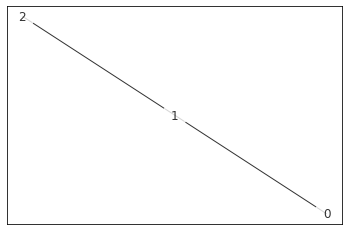

In [563]:
edges = 3
G = nx.Graph([(0,1),(1,2)])
A = nx.adjacency_matrix(G)
A = np.array(A.todense())


mc = maxcut(3, [[0,1], [1,2]])
mc.draw()

In [308]:
mc.build_circuit(depth = 2, beta = [0,0.3], gamma = [2,0])

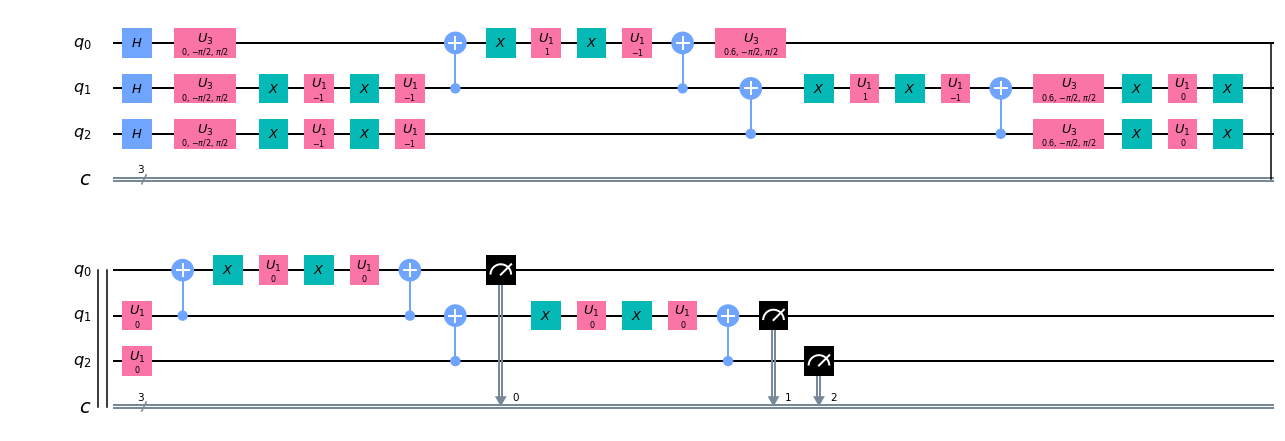

In [309]:
mc.circuit.circ.draw(output='mpl')

In [310]:
mc.solve(sims=10000)

{'010': 2221,
 '100': 930,
 '110': 933,
 '001': 881,
 '011': 918,
 '101': 2211,
 '111': 972,
 '000': 934}

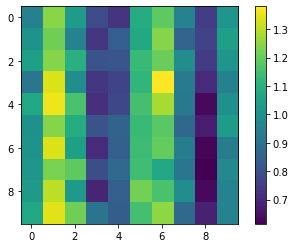

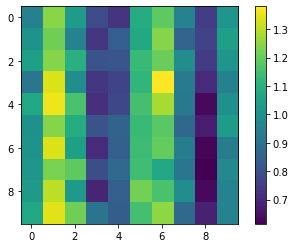

In [576]:
#Amount of samples from the grid
ngamma, nbeta = (10,10)

#Maybe only consider a section of the grid
sect = 1

#Creating the grid
gamma = np.linspace(0, pi*2/sect, ngamma)
beta = np.linspace(0, pi/sect, nbeta)

#Initializing rando variables
variance = np.zeros((ngamma,nbeta))
expectation = np.zeros((ngamma,nbeta))
expectation2 = np.zeros((ngamma,nbeta))
energy = np.zeros(2**3, dtype=int)

#Amount of simulations
shots = 200

#Calculating the energies that belong to each state. I think with a real quantum computer we could perhaps skip this.
for k in range(0,2**3):
    y = np.array([int(x) for x in '{0:03b}'.format(k)])
    energy[k] = int(np.sum(np.outer(y,(1-y)) * A))

#Find the expectation value for each point on the grid
for i in range(0,ngamma):
    for j in range(0,nbeta):
        mc.build_circuit(depth = 2, beta = [0,beta[j]], gamma = [2,gamma[i]])
        counts = mc.solve(sims=shots)
        
        #Variance stuff. Might be usefull, might not.
        #variance[i,j] = np.var(np.array(list(counts.values())))

        #re-ordering. counts for Jank, counts2 for Fancy
        counts = sorted(counts.items(), key = lambda x:(x[0], x[1]), reverse=True)
        counts2 = np.array(counts).astype(int)[::-1]
        
        #Fancy expectation
        expectation[i,j] = np.dot(np.array(energy),counts2[:,1])/shots
        
        #Janky expectation
        expectation2[i,j] = (2*counts[2][1]+2*counts[5][1]+counts[1][1]+counts[3][1]+counts[4][1]+counts[6][1])/shots

#Fancy expectation heatmap
plt.imshow(expectation);
plt.colorbar()
plt.show()

#Janky expectation heatmap
# plt.imshow(expectation2);
# plt.colorbar()
# plt.show()

#Variance stuff that might be useful but probs not
# plt.imshow(variance/shots);
# plt.colorbar()
# plt.show()

#Check if nothing went wrong with expectation (everything went as expected huehuehue ;) )
#print(expectation)
#print(expectation2)

In [448]:
grad = np.gradient(expectation)
plt.imshow(grad[1]);
plt.colorbar()
plt.show()

ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

In [433]:
G = nx.Graph([(0,1),(1,2)])
A = nx.adjacency_matrix(G)
A = np.array(A.todense())
w = -np.identity(3)+np.ones([3,3])
w[2,0] = 0
w[0,2] = 0
print(w)
x = np.array([0,1,0])
print(np.sum(np.outer(x,(1-x)) * w))
print(np.sum(np.outer(x,(1-x)) * A))
print('{0:03b}'.format(3))
print(np.array([int(x) for x in '{0:03b}'.format(2)]))

[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]
2.0
2
011
[0 1 0]
